# Práctica 2: Ejercicio 2 - Datos Energía: Modelos predictivos univariantes

**Asignatura**: Machine Learning, 2025/2026

**Profesor**: José Tomás Palma Méndez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Introducción

A continuación, pasaremos a la construcción de modelos predictivos univariantes. Es decir, intentaremos usar únicamente la información pasada de la propia variable objetivo para intentar predecirla en el futuro. Como se nos indica en el enunciado, buscamos predecir los 7 días siguientes a partir de los datasets dados, por tanto, tenemos un horizonte temporal de 7 días. Recordemos que la variable objetivo es la energía total consumida en un barrio.

## Librerías y datasets

Lo primero que hacemos es importar las librerías que vamos a utilizar.

In [1]:
# Predicción univariante de series temporales
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import random


from skforecast.metrics import root_mean_squared_scaled_error
from sklearn.metrics import mean_absolute_error,root_mean_squared_error, mean_squared_error
from xgboost import XGBRegressor

from skforecast.direct import ForecasterDirect
from skforecast.utils import save_forecaster

# Semillas para reproducibilidad
random.seed(123)
np.random.seed(123)

f:\UMU\Master IA\ML\practica1\.ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ahora cargamos los datos que ya hemos analizado y preprocesado en el apartado anterior.

In [2]:
# Cargamos nuestros dos datasets
energia_pre = pd.read_csv("Data/energia_preprocesada.csv", index_col=0, parse_dates=True)

Comprobamos que se ha cargado correctamente.

In [3]:
energia_pre

,Día de la semana,Electricidad (kW),Fotovoltaica (kW),Refrigeración (kW),Calefacción (kWh),Energía total (kWh),Emisión (kg CO₂)
2014-01-01,2,490049.280,62795.47,243369.71770,20107.60131,753526.59901,469960.0
2014-01-02,3,556486.560,64284.00,323886.05169,23987.86135,904360.47304,564020.0
2014-01-03,4,545831.450,67187.06,337004.60237,22112.20695,904948.25932,564390.0
2014-01-04,5,511495.560,46798.28,252493.06189,21074.73561,785063.35750,489640.0
2014-01-05,6,502806.800,70162.87,249265.37031,22777.47812,774849.64843,483270.0
...,...,...,...,...,...,...,...
2022-12-27,1,387412.640,30088.60,342464.92072,53687.67649,783565.23721,486790.0
2022-12-28,2,383053.165,5414.64,305114.02902,53895.75690,742062.95092,461820.0
2022-12-29,3,394671.370,19596.24,312909.24850,60730.17262,768310.79112,479160.0
2022-12-30,4,399327.275,13443.79,334773.31206,59543.23507,793643.82213,494110.0


Como estamos realizando predicción con modelos univariantes, nos quedamos sólo con la variable energía total. Haremos, por tanto, modelos predictivos autorregresivos en los que se usarán los datos de la serie temporal de esta variable para predecir los datos futuros.

In [4]:
#energia_pre.info()
energia_serie = pd.Series(energia_pre['Energía total (kWh)'])
energia_serie = energia_serie.asfreq('D')
energia_serie

2014-01-01    753526.59901
2014-01-02    904360.47304
2014-01-03    904948.25932
2014-01-04    785063.35750
2014-01-05    774849.64843
                  ...     
2022-12-27    783565.23721
2022-12-28    742062.95092
2022-12-29    768310.79112
2022-12-30    793643.82213
2022-12-31    772582.48209
Freq: D, Name: Energía total (kWh), Length: 3287, dtype: float64

Volvemos a comprobar que todos los datos están correctos. Deben ser 3287 entradas en punto flotante.

In [5]:
energia_serie.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3287 entries, 2014-01-01 to 2022-12-31
Freq: D
Series name: Energía total (kWh)
Non-Null Count  Dtype  
--------------  -----  
3287 non-null   float64
dtypes: float64(1)
memory usage: 51.4 KB


Vemos que todo ha ido bien. Vemos también que la frecuencia es diaria. Volvemos a comprobar que no nos faltan índices de fechas.

In [6]:
fechas_esperadas =  pd.date_range(start=energia_serie.index.min(), end=energia_serie.index.max(), freq='D')
fechas_perdidas = fechas_esperadas.difference(energia_serie.index)
print(f'Número de fechas faltantes: {len(fechas_perdidas)}')
fechas_perdidas

Número de fechas faltantes: 0


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Comprobamos visualmente que los datos de la serie están correctos en el dataset nuevo.

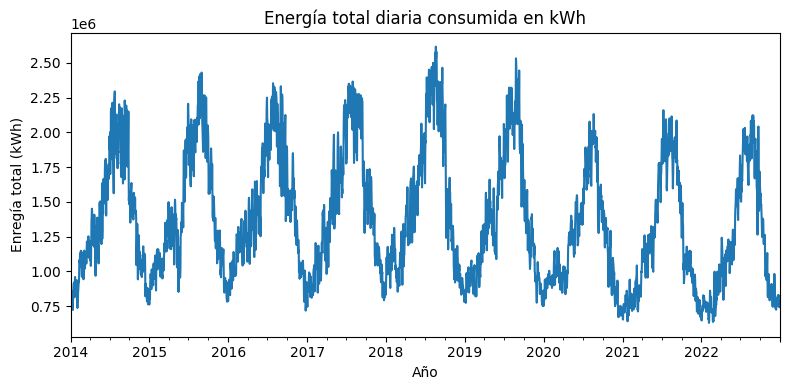

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
energia_serie.plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
fig.tight_layout()
plt.show()

Todo ha ido bien, aquí tenemos la serie temporal con la que trabajaremos en este notebook.

## Partición de los datos: Entrenamiento y Test

Lo que vamos a hacer a continuación es separar los valores de nuestra variable en datos de entrenamiento y test. Haremos un Hold-Out con un 80% de datos para entrenamiento y un 20% de datos para test. Debemos recordar que, como estamos tratando con series temporales, debemos hacer la partición de forma cronológica. Esto es, no podemos dividir los datos aleatoriamente, sino que los datos de entrenamiento serán los del principio de la serie (el 80% primero) y los de test serán los últimos que hay en esta (el 20% último). Como tenemos más de 3000 valores, hacemos una partición 80/20 en vez de una 90/10 porque consideramos que con más de 2600 valores tendremos más que suficientes datos para entrenar los modelos. Además, queremos tener suficientes datos de test para poder evaluar los modelo de forma más precisa.

In [8]:
porcentaje_split = .8
test_steps = int(len(energia_serie) * porcentaje_split)
energia_train = pd.Series(energia_serie[:test_steps])
energia_test = pd.Series(energia_serie[test_steps:])
print(f'Con el porcentaje de %.2f tenemos:' %porcentaje_split)
print(f'Tamaño del conjunto de training es %i' %len(energia_train))
print(f'Tamaño del conjunto de test es %i' %len(energia_test))
print(f'El conjunto de training va de {min(energia_train.index)} y {max(energia_train.index)}')
print(f'El conjunto de test va de {min(energia_test.index)} y {max(energia_test.index)}')

Con el porcentaje de 0.80 tenemos:
Tamaño del conjunto de training es 2629
Tamaño del conjunto de test es 658
El conjunto de training va de 2014-01-01 00:00:00 y 2021-03-13 00:00:00
El conjunto de test va de 2021-03-14 00:00:00 y 2022-12-31 00:00:00


Veamos visualmente cómo hemos hecho la partición.

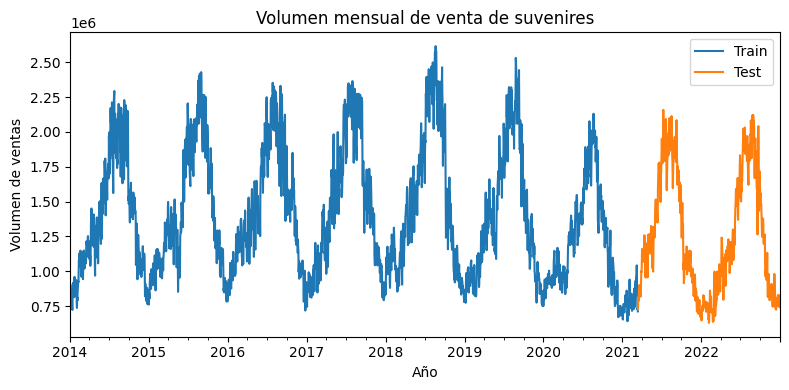

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
ax.legend(labels=['Train', 'Test'], loc='best')
ax.set_xlabel('Año')
ax.set_ylabel('Volumen de ventas')
ax.set_title('Volumen mensual de venta de suvenires')
fig.tight_layout()
plt.show()

Vemos que efectivamente, hemos realizado correctamente la partición de los datos. Vemos además, cómo se respeta la partición cronológica: los datos de entrenamiento van desde 2014 hasta principios de 2021 y los de test, desde comienzos del 2021 hasta el final del 2022.

## Entrenamiento de modelo baseline

Como primera aproximación a la predicción de los datos, vamos a entrenar un primer modelo baseline. Como su nombre indica, este nos servirá como modelo de línea base a partir del cual intentaremos mejorar el rendimiento ofrecido en los futuros modelos. Por tanto, no haremos ningún tipo de transformación ni diferenciación en los datos en este primer entrenamiento. Además, como buscamos un primer modelo base fácil de computar, tampoco haremos búsqueda de hiperpárametros en este modelo y usaremos sus parámetros por defecto. 

Como modelo baseline escogemos ***LightGBM*** por ser este eficaz, rápido de ejecutar y fácilmente interpretable, pues está basado en la potenciación de gradiente de árboles de regresión.

Como esquema de predicción, **usaremos la técnica recursiva** en toda la práctica puesto que, a pesar de que el error se va acumulando a lo largo de las predicciones, esta mantiene la dependencia estadística temporal de las mismas. Además, al ser el horizonte temporal a predecir tan pequeño (7 días) en comparación con todo el volumen de datos que tenemos, esperamos que el error acumulado sea muy pequeño. También escogemos esta estrategia por ser **más eficiente computacionalmente**, puesto que sólo entrenamos un modelo cada vez (frente a los 7 que entrenaríamos si utilizásemos la predicción directa), y esto será importante cuando tengamos que usar varias variables o tengamos grandes parrillas de hiperparámetros. Usaremos como ventana temporal **365 días**, puesto que ya vimos en el análisis de los datos que hay una estacionalidad que se corresponde con un año de los datos.

In [10]:
from skforecast.recursive import ForecasterRecursive
from lightgbm import LGBMRegressor

forecaster_LGBM = ForecasterRecursive(
                regressor = LGBMRegressor(random_state=123, n_jobs=-1, verbose = -1),
                lags = 365,
                differentiation=None
             )
forecaster_LGBM.fit(y=energia_train)
forecaster_LGBM

C:\Users\vecto\AppData\Local\Temp\ipykernel_4376\3806696798.py:4: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster_LGBM = ForecasterRecursive(


=================== 
ForecasterRecursive 
=================== 
Estimator: LGBMRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365] 
Window features: None 
Window size: 365 
Series name: Energía total (kWh) 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2021-03-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-12-21 15:55:39 
Last fit date: 2025-12-21 15:55:39 
Skforecast version: 0.19.1 
Python version: 3.12.7 
Forecaster id: None

Una vez entrenado el modelo, generamos las predicciones.

In [11]:
steps = len(energia_test)
predicciones = forecaster_LGBM.predict(steps=steps)
predicciones

2021-03-14    738292.744621
2021-03-15    797386.205960
2021-03-16    789018.336484
2021-03-17    771462.210159
2021-03-18    756605.585699
                  ...      
2022-12-27    690914.715509
2022-12-28    690914.715509
2022-12-29    690914.715509
2022-12-30    690914.715509
2022-12-31    690914.715509
Freq: D, Name: pred, Length: 658, dtype: float64

Vemos la representación gráfica de las predicciones.

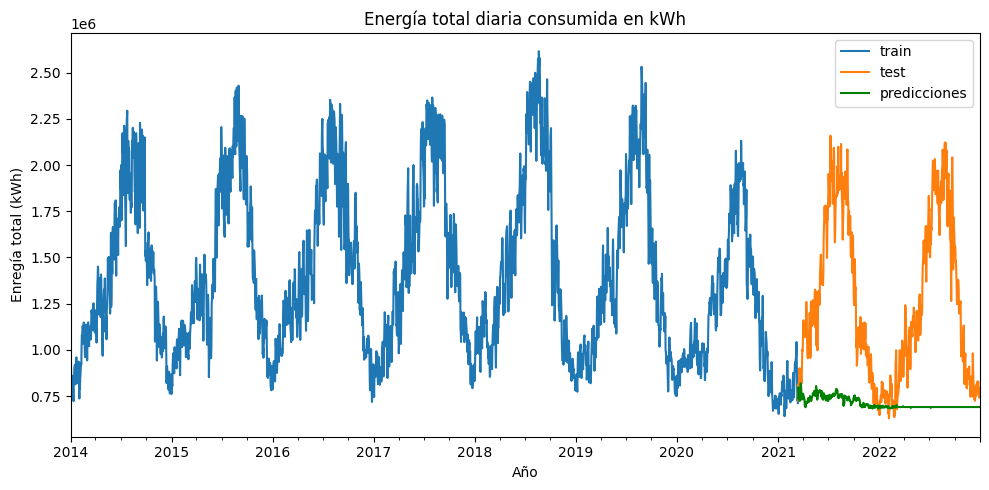

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

### Evaluación del modelo

Hacemos ahora el cálculo de las métricas de error. Escogemos como métricas principales el error medio absoluto (`MAE`), la raíz del error cuadrático medio (`RMSE`), la raíz del error cuadrático medio escalado (`RMSSE`) y el error porcentual absoluto medio (`MAPE`).


**Interpretación de las métricas:**
- **MAE** (Mean Absolute Error): Error absoluto medio en kWh. Más bajo es mejor. Elegimos esta métrica porque es más directa e intuitiva para analizar el error cometido. El error está en las mismas unidades de la serie y es más robusta a valores atípicos que métricas cuadráticas.
- **RMSE** (Root Mean Squared Error): Penaliza más los errores grandes. Más bajo es mejor. Elegimos esta métrica porque es más sensible a cambios bruscos grandes. Es útil en problema como este en los que queremos minimizar errores extremos para predecir, por ejemplo, cuánta energía se deberá producir para un barrio determinado.
- **RMSSE** (Root Mean Squared Scaled Error): Mide el error del modelo escalado por el error de un modelo ingenuo, respetando la estructura temporal. El RMSSE evalúa el funcionamiento relativo del modelo frente a una predicción mínima razonable, lo cual es crucial en series temporales. Nos permite saber si el modelo realmente mejora un baseline simple.
- **MAPE** (Mean Absolute Percentage Error): Error porcentual medio. Más bajo es mejor. Elegimos esta métrica porque nos da en porcentaje el error medio cometido. Esto hace que sea muy fácil de interpretar y que sea independiente de la escala.

Procedemos ahora a construir una función que nos calcule estas métricas dadas unas predicciones y sus valores reales.

In [38]:
# Función para calcular métricas de evaluación
def calcular_metricas(y_true, y_pred, nombre_modelo="Modelo", verbose=True):
    """
    Calcula métricas de evaluación para predicciones de series temporales.
    
    Métricas:
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error
    - RMSSE: Root Mean Squared Scaled Error
    - MAPE: Mean Absolute Percentage Error
    """
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # RMSSE (Root Mean Squared Scaled Error)
    # Escala usando las diferencias consecutivas de la serie real
    scale = np.mean(np.diff(y_true)**2)
    rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
    
    # MAPE (Mean Absolute Percentage Error)
    # Evitar división por cero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.inf
    
    resultados = {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'RMSE': rmse,
        'RMSSE': rmsse,
        'MAPE': mape
    }
    
    if verbose:
        print(f"\nMétricas de {nombre_modelo}:")
        print(f"  • MAE   = {mae:.3f} kWh")
        print(f"  • RMSE  = {rmse:.3f} kWh")
        print(f"  • RMSSE = {rmsse:.4f}")
        print(f"  • MAPE  = {mape:.2f}%")
    
    return resultados

Ahora, procedemos a crear una función personalizada que nos permita calcular las predicciones para cada uno de los puntos de test. Lo hacemos de forma que podamos crear la predicción del horizonte temporal (los 7 días siguientes) para cada uno de ellos. De esta manera, podremos calcular los errores del h+1, h+2, .. h+7 de manera independiente para cada uno de los datos de test. Lo que hacemos será: escogemos los últimos datos de training, creamos las predicciones de los siguiente 7 días, calculamos los errores y movemos en un día la ventana, por lo que la nueva ventana temporal contendrá un dato menos del conjunto de training y el primer dato del conjunto de test. Repetimos esto para todo el conjunto de test.

In [41]:
# Función para calcular errores por horizonte de predicción de forma individual
def calcular_errores_por_horizonte(modelo, test_data, train_data=None, offset_lags=0, exog_test=None, horizonte=7, target_col='Energía total (kWh)', verbose=True):
    # Si se proporcionan datos de train, concatenarlos con test para tener suficientes lags
    if train_data is not None:
        # Concatenar últimos 365 días de train con test
        datos_completos = pd.concat([train_data.tail(offset_lags), test_data])
        # Ajustar índice de inicio
        offset = offset_lags
    else:
        datos_completos = test_data
        offset = 0
    
    # Inicializar listas para almacenar errores
    errores_por_ventana = []
    predicciones_lista = []
    
    # Calcular cuántas ventanas de predicción podemos hacer
    n_ventanas = len(test_data) - horizonte + 1
    
    # Para cada ventana de inicio en el conjunto de test
    for i in range(n_ventanas):
        # Índice en test_data
        idx_test = i
        # Índice en datos_completos
        idx_completo = i + offset
        
        # Fecha de inicio de la predicción
        fecha_inicio = test_data.index[idx_test]
        
        # Realizar predicción para los próximos 'horizonte' días
        # Datos hasta el punto de predicción (incluye train si está disponible)
        datos_hasta_punto = datos_completos.iloc[:idx_completo]
        
        if  exog_test is not None:
            # Variables exógenas para el periodo de predicción
            exog_periodo = exog_test.iloc[idx_test:idx_test+horizonte]
            pred = modelo.predict(steps=horizonte, 
                                 last_window=datos_hasta_punto, exog=exog_periodo)
        else:
            pred = modelo.predict(steps=horizonte,
                                 last_window=datos_hasta_punto)
        
        # Obtener valores reales para este periodo
        y_true = test_data.iloc[idx_test:idx_test+horizonte].values
        
        # Extraer predicciones solo para la serie objetivo
        # pred puede ser un DataFrame con múltiples series
        y_pred = pred

        # Asegurarse de que las dimensiones coinciden
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        # Calcular error absoluto para cada día del horizonte
        errores_ventana = np.abs(y_true - y_pred)
        
       # Calcular errores
        error_abs = np.abs(y_true - y_pred)
        error_squared = (y_true - y_pred) ** 2
        error_pct = np.abs((y_true - y_pred) / y_true) * 100
        
        # Guardar predicciones
        for h in range(min_len):
            predicciones_lista.append({
                'ventana': i,
                'fecha_inicio': fecha_inicio,
                'horizonte_dia': h + 1,
                'fecha_pred': test_data.index[idx_test + h],
                'valor_real': float(y_true[h]),
                'valor_pred': float(y_pred.iloc[h]),
                'error_absoluto': float(error_abs.iloc[h]),
                'error_cuadrado': float(error_squared.iloc[h]),
                'error_porcentual': float(error_pct.iloc[h])
            })
        
        # Guardar errores de esta ventana
        errores_ventana_dict = {'ventana': i, 'fecha_inicio': fecha_inicio}
        for h in range(min_len):
            errores_ventana_dict[f'mae_h{h+1}'] = float(error_abs.iloc[h])
            errores_ventana_dict[f'mse_h{h+1}'] = float(error_squared.iloc[h])
            errores_ventana_dict[f'mape_h{h+1}'] = float(error_pct.iloc[h])

        errores_por_ventana.append(errores_ventana_dict)
    
    # Crear DataFrames
    df_errores = pd.DataFrame(errores_por_ventana)
    df_predicciones = pd.DataFrame(predicciones_lista)
    
    if len(df_predicciones) == 0:
        return None
    
    # Calcular métricas por horizonte
    metricas_por_h = []
    for h in range(1, horizonte + 1):
        # Filtrar predicciones para este horizonte
        pred_h = df_predicciones[df_predicciones['horizonte_dia'] == h]
        
        y_true_h = pred_h['valor_real'].values
        y_pred_h = pred_h['valor_pred'].values
        
        # MAE
        mae = np.mean(np.abs(y_true_h - y_pred_h))
        
        # RMSE
        mse = np.mean((y_true_h - y_pred_h) ** 2)
        rmse = np.sqrt(mse)
        
        # RMSSE (Root Mean Squared Scaled Error)
        scale = np.mean(np.diff(y_true_h)**2) if len(y_true_h) > 1 else 1
        rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
        
        # MAPE
        mask = y_true_h != 0
        mape = np.mean(np.abs((y_true_h[mask] - y_pred_h[mask]) / y_true_h[mask])) * 100 if mask.sum() > 0 else np.inf
        
        metricas_por_h.append({
            'Horizonte': f'h+{h}',
            'MAE': mae,
            'RMSE': rmse,
            'RMSSE': rmsse,
            'MAPE': mape
        })
    
    df_metricas = pd.DataFrame(metricas_por_h)
    
    # Calcular métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }

    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'errores_detallados': df_errores,
        'predicciones': df_predicciones
    }

# Función para visualizar errores por horizonte
def visualizar_errores_horizonte(resultados, titulo="Análisis de Errores por Horizonte"):
    df_metricas = resultados['metricas_por_horizonte']
    df_predicciones = resultados['predicciones']
        
    n_horizontes = df_predicciones['horizonte_dia'].nunique()
    fig, axes = plt.subplots(n_horizontes, 1, figsize=(16, 4 * n_horizontes))
    
    if n_horizontes == 1:
        axes = [axes]
    
    for h in range(1, n_horizontes + 1):
        ax = axes[h - 1]
        
        # Filtrar datos para este horizonte
        datos_h = df_predicciones[df_predicciones['horizonte_dia'] == h].sort_values('fecha_pred')
        
        # Plotear valores reales y predichos
        ax.plot(datos_h['fecha_pred'], datos_h['valor_real'], 
               'o-', color='steelblue', label='Valores Reales', 
               linewidth=2, markersize=4, alpha=0.8)
        
        ax.plot(datos_h['fecha_pred'], datos_h['valor_pred'], 
               's--', color='orangered', label='Predicciones', 
               linewidth=2, markersize=4, alpha=0.8)
        
        # Área de error
        ax.fill_between(datos_h['fecha_pred'], 
                        datos_h['valor_real'], 
                        datos_h['valor_pred'],
                        alpha=0.2, color='gray')
        
        # Métricas para este horizonte
        metrica_h = df_metricas[df_metricas['Horizonte'] == f'h+{h}'].iloc[0]
        texto_metricas = (f"MAE: {metrica_h['MAE']:.2f} | "
                         f"RMSE: {metrica_h['RMSE']:.2f} | "
                         f"RMSSE: {metrica_h['RMSSE']:.4f} | "
                         f"MAPE: {metrica_h['MAPE']:.2f}%")
        
        ax.set_xlabel('Fecha', fontsize=11, fontweight='bold')
        ax.set_ylabel('Energía (kWh)', fontsize=11, fontweight='bold')
        ax.set_title(f'Horizonte h+{h} - {texto_metricas}', 
                    fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Rotar etiquetas de fecha si hay muchos puntos
        if len(datos_h) > 30:
            ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'{titulo} - Predicciones por Horizonte', 
                fontsize=14, fontweight='bold', y=0.9995)
    plt.tight_layout()
    plt.show()

In [15]:
error_mae = mean_absolute_error(
                y_true = energia_test,
                y_pred = predicciones
            )
print(f"Error absoluto medio (mae): {error_mae:.3f}")

error_rmse = root_mean_squared_error(
                y_true = energia_test,
                y_pred = predicciones
            )
print(f"Raíz del error cuadrático medio (rmse): {error_rmse:.3f}")

error_rmsse = root_mean_squared_scaled_error(
                y_true = energia_test,
                y_pred = predicciones,
                y_train = energia_train
            )
print(f"Raíz del error cuadrático medio escalado (rmsse): {error_rmsse:.3f}")

# Guardamos los resultados en un diccionario
resultadosBase = {
        'Modelo': 'Baseline',
        'MAE': error_mae,
        'RMSE': error_rmse,
        'RMSSE': error_rmsse
    }
# Guardamos los resultados del modelo
metricas_modelos = [resultadosBase]

Error absoluto medio (mae): 553893.107
Raíz del error cuadrático medio (rmse): 695340.422
Raíz del error cuadrático medio escalado (rmsse): 6.661


Vemos que tenemos un MAE y RMSE bastantes grandes, aunque no lo es tanto si lo comparamos con la escala de los datos. Si vemos la gráfica anterior, vemos que la predicción no es muy buena, pero que casi captar la estacionalidad de los datos en el primer año. Vemos que conforme avanzan los datos, las predicciones son cada vez peores.

Intentaremos mejorar estos datos entrenandos los modelos principales que compararemos.

## Entrenamiento de modelos principales

A continuación, entrenaremos los modelos principales que usaremos para crear nuestras predicciones. Elegimos como modelos principales los siguientes:
* **XGBoost**. Escogemos este por ser muy eficiente computacionalmente y mostrar muy buen rendimiento en problemas complejos. Además, incluye regularización, lo que disminuye el overfitting. Además, es fácil de interpretar porque se basan en potenciación de gradiente de árboles de regresión.
* **RandomForest**. Escogemos este por ser muy robusto y permitir una gran interpretabilidad de los resultados calculados. Nos permite además calcular la importancia relativa de las variables.
* **SVR**. Escogemos este por ser muy eficaz en datasets medianos y ser menos sensible al ruido que otros modelos. Es adecuado cuando buscamos una buena generalización.

Ordenamos según su interpretabilidad, tenemos que RandomForest es el más interpretable de los 3 y SVR el que menos. Esto puede ser también una característica a tener en cuenta cuando los modelos tengan rendimientos muy similares.

Intentaremos mejorar los resultados anteriores ajustando estos modelos haciendo una búsqueda con grid de hiperparámetros.

### XGBoost

Creamos nuestro modelo XGBoost. Al igual que antes usaremos predicción recursiva.

In [16]:

# Creamos el modelo con predicción recursiva
forecaster_XGB = ForecasterRecursive(
                 regressor       = XGBRegressor(random_state=123, n_jobs=-1),
                 lags            = 365, #este valor se sobreecribe en la búsqueda de hiperparámetros
                 differentiation = None
             )

C:\Users\vecto\AppData\Local\Temp\ipykernel_4376\554260495.py:2: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster_XGB = ForecasterRecursive(


Definimos nuestros grids para las variables lag y el grid de hiperparámetros de nuestro modelo. Para los hiperparámetros usamos los valores por defecto y los variamos ligeramente:

* **learning_rate**: escogemos el valor por defecto, 0.3, y los disminuimos ligeramente, 0.2 y 0.1. Valores pequeños suelen funcionar bien para las tasas de aprendizaje.
* **max_depth**: escogemos el valor por defector, 6, y escogemos uno mayor y otro menor, 3 y 9. Normalmente, árboles más profunods son más exactos pero tienen más riesgo de overfitting.
* **min_child_weight**: escogemos el valor por defecto, 1, lo aumentamos ligeramente, 3 y 5. Cuanto más grande sea el valor, más conservador será el algoritmo al hacer la regresión e incluir instancias en los nodos.


Para el grid de lags, usamos como ventana temporal: 
* Una semana de datos, **7 días**, porque como hemos visto en el notebook anterior, la serie presenta una gran autocorrelación para los datos de la semana anterior, por lo que puede haber una estacionalidad semanal. 
* Un mes, **30 días**, porque también vimos que había una correlación notable para los datos del mes anterior, pudiendo haber estacionalidad mensual.
* Medio año, **183 días**, porque vimos que existía una correlación negativa notable para cada dato de la serie con los del medio año anterior.
* Un año, **365 días**, porque hemos visto que la serie tiene estacionalidad anual.
* La semana anterior y la misma semana del año anterior, porque si tiene una gran correlación con la semana anterior y una estacionalidad anual, es posible que sólo estos 14 valores sean suficientes para realizar una buena predicción.

In [17]:
lags_grid = [7, 30, 183 ,365, [1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]]

#Creamos el grid de hiperparámetros
param_grid_xgboost = {
    'learning_rate': [0.3, 0.2,0.1],
    'max_depth': [3,6,9],
    'min_child_weight': [1,3,5],
    
}

Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días. Usamos un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo. Cuanto más grande sea este valor, menos pliegues tendremos en la validación cruzada. Consideramos 2 años justos como para tener suficientes datos y no tener demasiados pliegues. No reentrenamos el modelo en cada pliegue. Usamos una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, **no usamos diferenciación** porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 


In [18]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster
from skforecast.model_selection import TimeSeriesFold

cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = 730,
         fold_stride           = None,
         window_size           = 365,
         refit                 = False,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation       = None,
         verbose               = False
     )

Pasamos ahora a optimizar el modelo usando el grid de hiperparámetros.

In [19]:
results_grid_XGB = grid_search_forecaster(
                   forecaster         = forecaster_XGB,
                   y                  = energia_train,
                   param_grid         = param_grid_xgboost,
                   lags_grid          = lags_grid,
                   cv                 = cv,
                   metric             = 'root_mean_squared_scaled_error',
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )


lags grid: 100%|██████████| 5/5 [01:21<00:00, 16.22s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5}
  Backtesting metric: 1.4165521498501363


Vemos que los mejores parámetros son **0.1** para learning rate, **3** para max_depth y **5** para min_child_weight. La métrica de raíz de error cuadrático medio escalado del mejor modelo ha sido de **1.41**, BASELINE.

Vemos los errores y parámetros de cada modelo del grid.

In [20]:
results_grid_XGB

,lags,lags_label,params,root_mean_squared_scaled_error,learning_rate,max_depth,min_child_weight
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",1.416552,0.1,3.0,5.0
1,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",1.425850,0.1,3.0,1.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",1.425959,0.1,3.0,1.0
3,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",1.426815,0.1,3.0,5.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",1.427245,0.1,3.0,3.0
...,...,...,...,...,...,...,...
130,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.2, 'max_depth': 9, 'min_ch...",1.785880,0.2,9.0,5.0
131,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 9, 'min_ch...",1.786364,0.3,9.0,5.0
132,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 6, 'min_ch...",1.794198,0.3,6.0,3.0
133,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.3, 'max_depth': 9, 'min_ch...",1.795205,0.3,9.0,3.0


Veamos los parámetros del mejor modelo.

In [21]:
forecaster_XGB

=================== 
ForecasterRecursive 
=================== 
Estimator: XGBRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window features: None 
Window size: 30 
Series name: Energía total (kWh) 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2021-03-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': False, 'eval_metric': None, 'feature_types': None,
    'feature_weights': None, 'gamma': None, 'grow_policy': None,
    'importance_type': None, 'interaction_constraints': None, 'learning_rate':
    0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None,
    'max_delta_step': None, 'max_depth': 3, 'max_leaves': None,
    'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None,
    'multi_strategy': None, 'n_estimators': None, 'n_jobs': -1,
    'num_parallel_tree': None, 'random_state': 123, 'reg_alpha': None,
    'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None,
    'subsample': None, 'tree_method': None, 'validate_parameters': None,
    'verbosity': None} 
fit_kwargs: {} 
Creation date: 2025-12-21 15:55:40 
Last fit date: 2025-12-21 15:57:01 
Skforecast version: 0.19.1 
Python version: 3.12.7 
Forecaster id: None

Vemos que los mejores parámetros son **0.1** para learning rate, **3** para max_depth y **5** para min_child_weight. El mejor número de lags detectado es **30**.  Vemos cuál es la importancia que se le da a los lags seleccionados.

In [22]:
# Vemos la importanca de las características
importance_df =forecaster_XGB.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100
    
print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

   feature importance
0    lag_1     66.30%
5    lag_6     11.50%
6    lag_7     10.25%
13  lag_14      1.58%
4    lag_5      0.78%
12  lag_13      0.75%
19  lag_20      0.56%
23  lag_24      0.54%
20  lag_21      0.47%
18  lag_19      0.47%
27  lag_28      0.44%
22  lag_23      0.44%
29  lag_30      0.44%
15  lag_16      0.42%
28  lag_29      0.42%
25  lag_26      0.39%
21  lag_22      0.39%
8    lag_9      0.39%
14  lag_15      0.37%
11  lag_12      0.34%


Podemos ver cómo, sobre todo, el valor más importante es el del día anterior, con un 66.3% de importancia. Después, los siguientes más imporantes son el valor de hace 6 días y de hace una semana, con 11.5% y 10.25% respectivamente. Veamos ahora cómo se comporta prediciendo el conjunto de test. Predecimos primero usando como horizonte todos los puntos de test, para ver cómo se comporta.

In [23]:
predicciones_grid = forecaster_XGB.predict(steps=len(energia_test))
predicciones_grid

2021-03-14    780449.2500
2021-03-15    835755.1875
2021-03-16    838011.5625
2021-03-17    824586.6250
2021-03-18    813639.3125
                 ...     
2022-12-27    923938.5000
2022-12-28    923938.5000
2022-12-29    923938.5000
2022-12-30    923938.5000
2022-12-31    923938.5000
Freq: D, Name: pred, Length: 658, dtype: float64

A simple vista, los valores parecen muy similares. Comparamos gráficamente las predicciones con los valores reales de test.

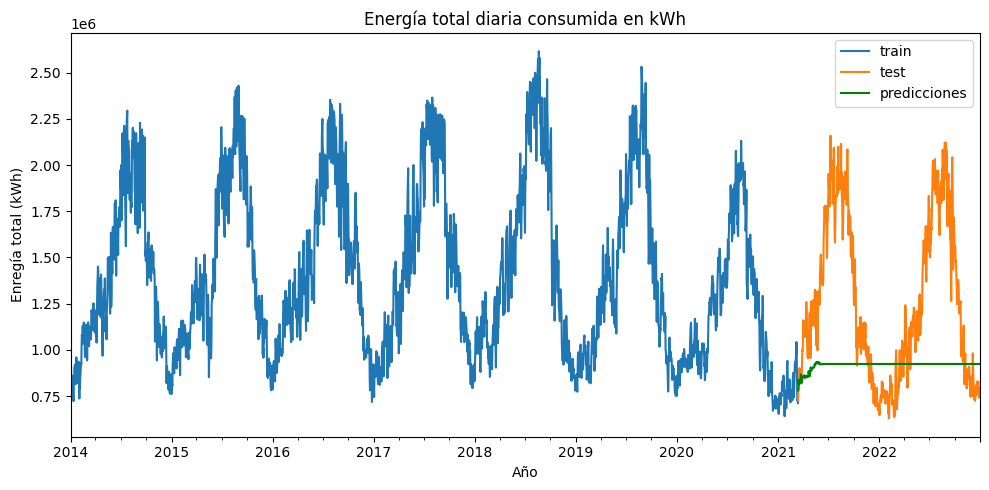

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predicciones_grid.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

Vemos que el modelo predice muy mal los ejemplos de test. A simple vista en la gráfica, como indicábamos antes, todos los valores son aproximadamente iguales. Sin embargo, esto puede tener una explicación muy clara: el modelo se ha entrenado para predecir un horizonte temporal de 7 valores, o sea, para predecir 7 días. Y aquí, le estamos pidiendo que nos prediga todo el conjunto de test, que se trata de un total de 658 valores. Por tanto, como estamos usando predicción recursiva, los errores en cada predicción se van acumulando poco a poco hasta el punto de que los valores se van estabilizando y como el mejor modelo usa un lag de 7 días, se van generando valores iguales. Entonces, esta gráfica no nos está mostrando adecuadamente cómo se comporta nuestro modelo cuando lo que queremos predecir son sólo los próximos 7 días.

Antes de solucionar esto, veamos cuáles son los errores según estas predicciones.

In [25]:
error_mae = mean_absolute_error(
                y_true = energia_test,
                y_pred = predicciones_grid
            )
print(f"Error absoluto medio (mae): {error_mae:.3f}")

error_rmse = root_mean_squared_error(
                y_true = energia_test,
                y_pred = predicciones_grid
            )
print(f"Raíz del error cuadrático medio (rmse): {error_rmse:.3f}")

error_rmsse = root_mean_squared_scaled_error(
                y_true = energia_test,
                y_pred = predicciones_grid,
                y_train = energia_train
            )
print(f"Raíz del error cuadrático medio escalado (rmsse): {error_rmsse:.3f}")

Error absoluto medio (mae): 417217.762
Raíz del error cuadrático medio (rmse): 548132.216
Raíz del error cuadrático medio escalado (rmsse): 5.250


Vemos que con estas predicciones tenemos unos errores muy grandes. BASELINE.

Para comprobar de una manera más real cómo se comporta nuestro modelo para predecir horizontes de 7 días podemos usar la función anteriormente definida. Como el modelo está entrenado para predecir los siguientes 7 valores, lo que haremos será lo siguiente: ir generando las predicciones de los 7 días siguientes día a día, comparándolas con los valores reales del conjunto de test y añadiendo en cada nueva iteración, el último valor real del conjunto de test. Usamos como primeros valores para predecir, los últimos del conjunto de entrenamiento.

In [44]:
resultados_xgb = calcular_errores_por_horizonte(
    modelo=forecaster_XGB,
    test_data=energia_test,
    train_data=energia_train,  # Añadir esto para tener suficientes lags
    offset_lags=max(forecaster_XGB.lags),
    exog_test=None,
    horizonte=7,
    target_col='Energía total (kWh)',
    verbose=True
)

resultados_xgb

{'metricas_por_horizonte':   Horizonte            MAE           RMSE     RMSSE      MAPE
 0       h+1   58903.466948   78107.683436  0.991892  4.791542
 1       h+2   86217.145039  113845.299353  1.446669  7.078849
 2       h+3  100648.685299  130937.428131  1.664020  8.270609
 3       h+4  108138.952988  139585.756894  1.774003  8.910370
 4       h+5  113384.776840  145513.683732  1.849834  9.374155
 5       h+6  116746.112331  149665.933831  1.902530  9.640471
 6       h+7  120501.909604  154419.610243  1.963037  9.934468,
 'metricas_globales': {'MAE': np.float64(100648.72129286187),
  'RMSE': np.float64(130296.48508861799),
  'RMSSE': np.float64(1.6559976957808498),
  'MAPE': np.float64(8.285780611369114)},
 'errores_detallados':      ventana fecha_inicio       mae_h1        mse_h1   mape_h1       mae_h2  \
 0          0   2021-03-14  52193.13319  2.724123e+09  7.166865  22337.45288   
 1          1   2021-03-15  24537.29712  6.020789e+08  3.016568  26632.79902   
 2          2   20

Vemos cómo son las nuevas predicciones con esta técnica alternativa.

A simple vista no podemos decir mucho de estos valores. Veamos ahora comparándolos gráficamente con los reales.

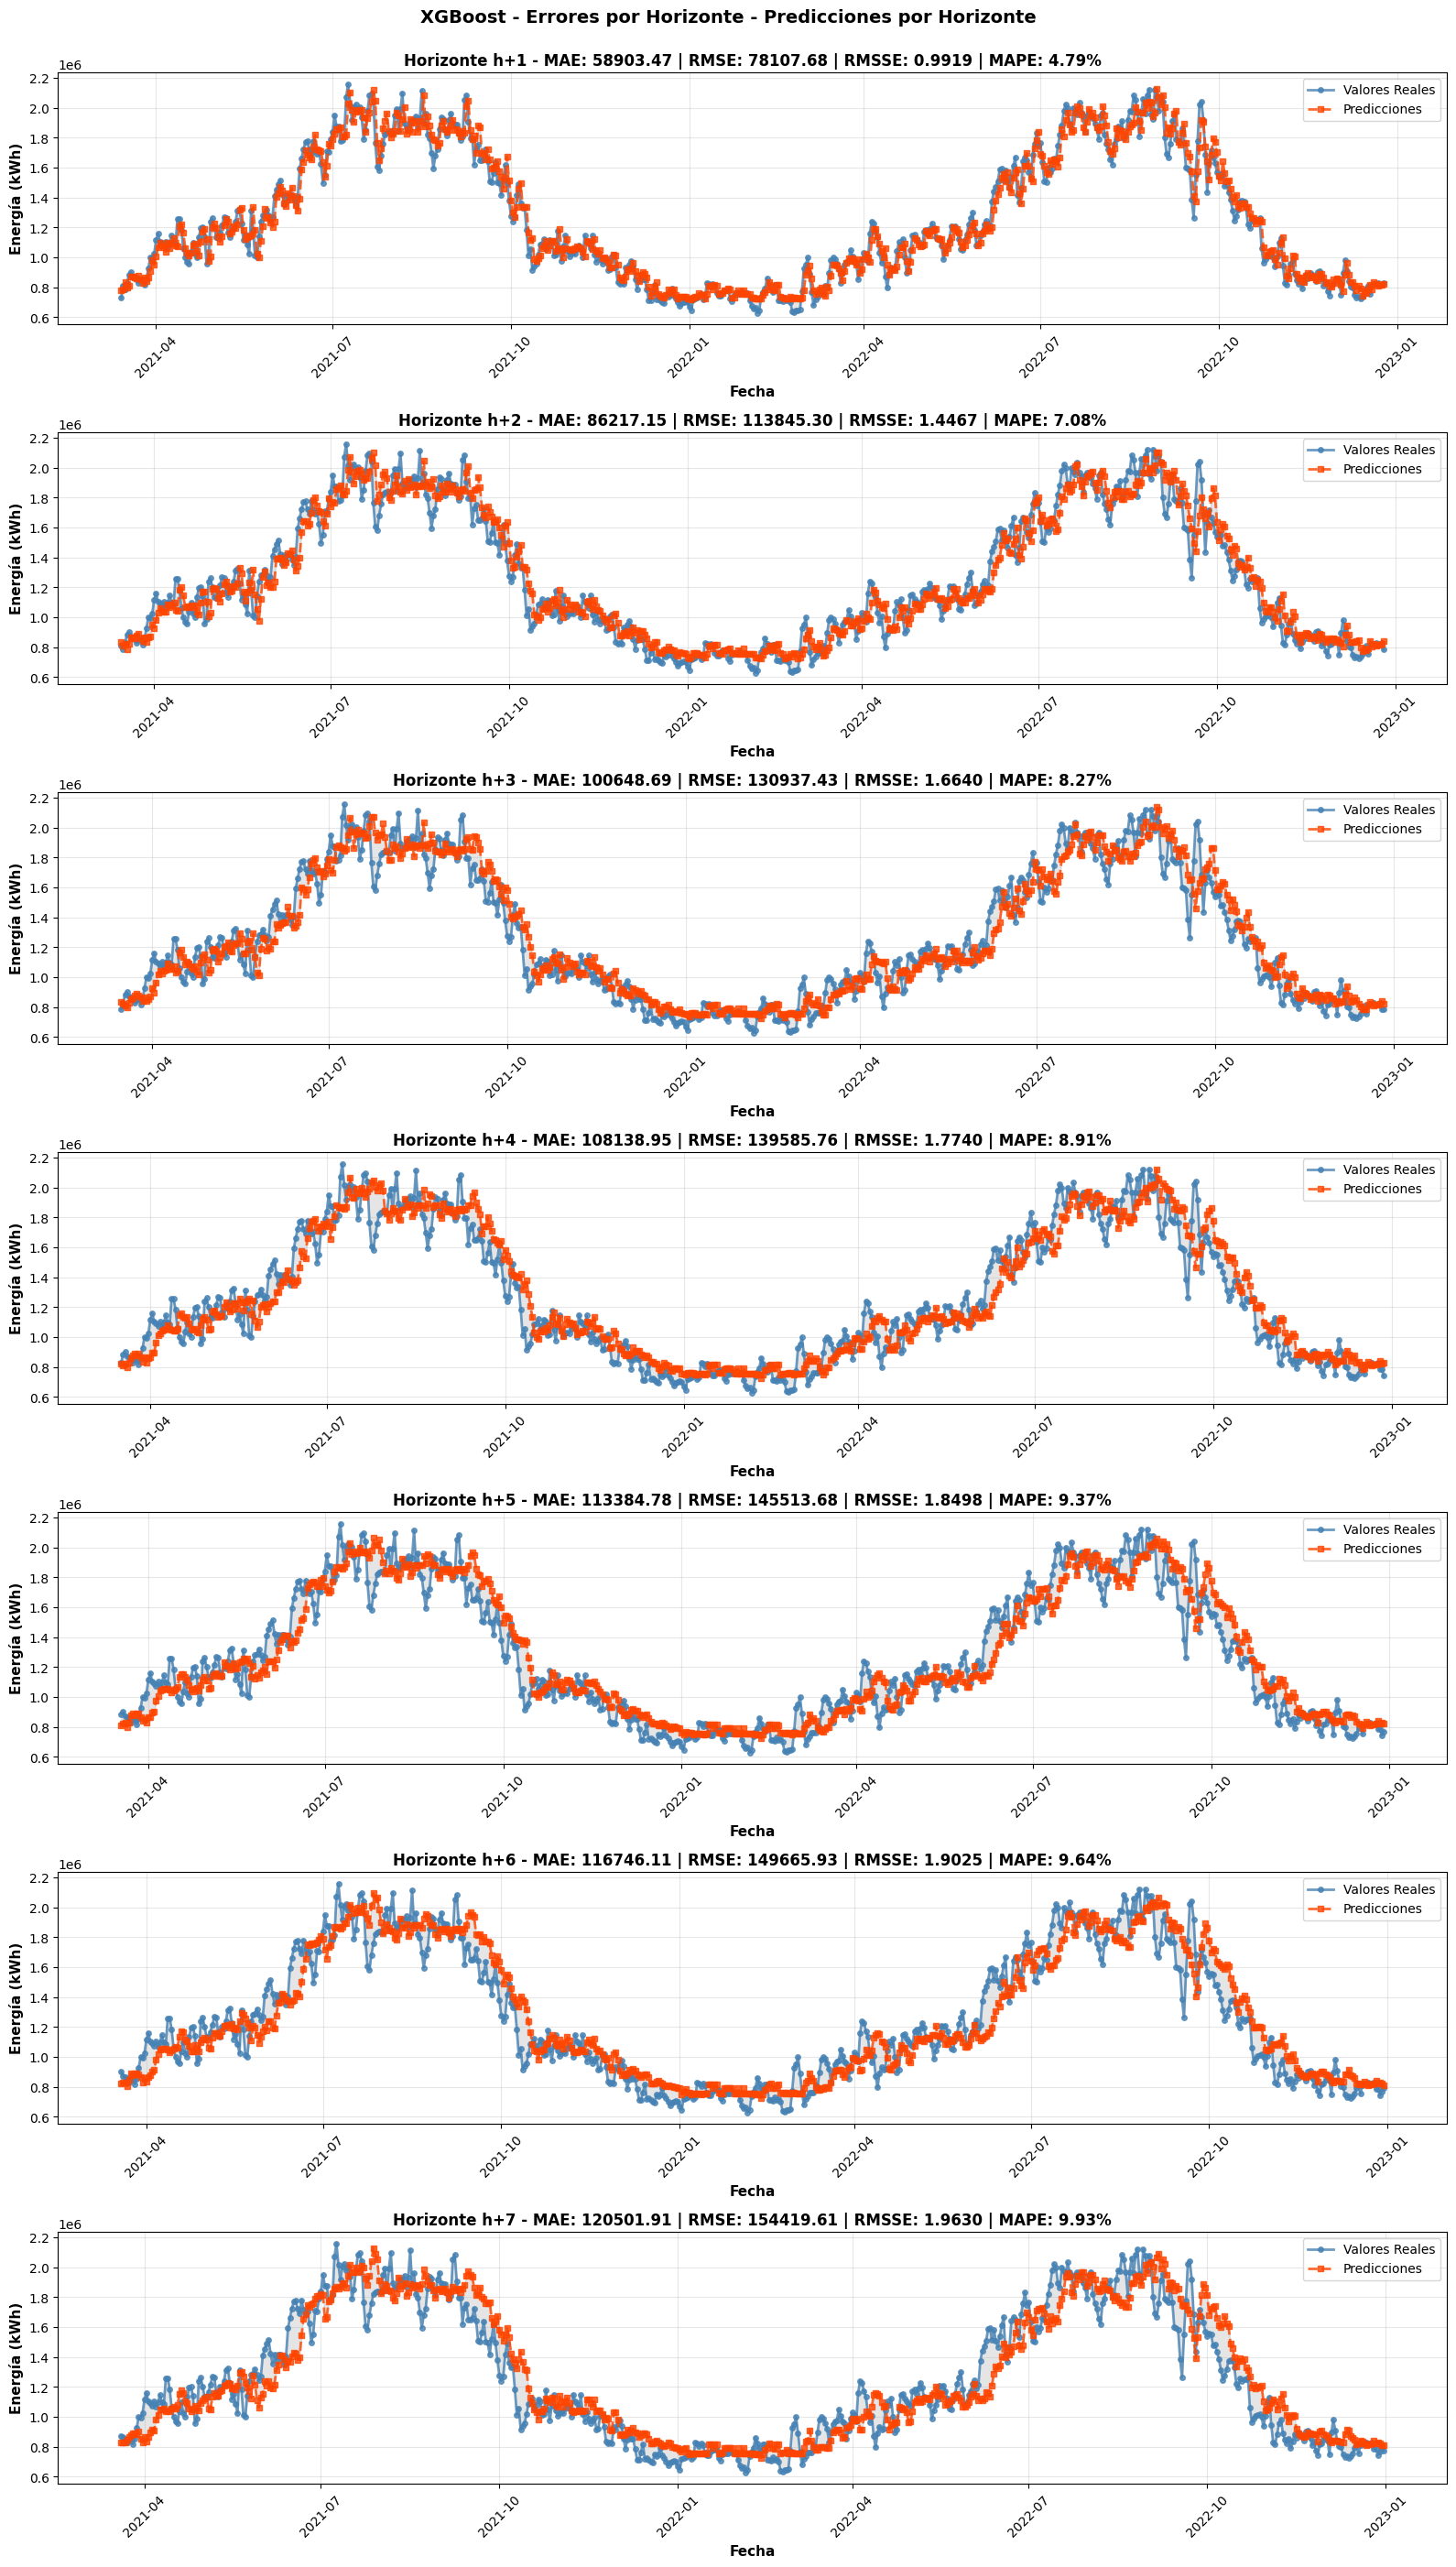

In [45]:
visualizar_errores_horizonte(resultados_xgb, titulo="XGBoost - Errores por Horizonte")

Ahora sí, podemos ver cómo generando las predicciones de esta manera, el modelo se está comportando muy bien. Cuando vamos prediciendo los valores de 1 en 1, las predicciones consecutivas son muy buenas. De esta manera podemos afirmar que nuestro modelo en realidad sí que se comporta muy bien cuando queremos predecir valores en un horizonte temporal de 7 días.

Vemos perfectamente cómo las mejores predicciones son las de los valores h+1, es decir, las del día siguiente al que nos encontramos, obteniendo **un MAE de 58903.47, un RMSE de 78107.68, un RMSSE de 0.9919 y un MAPE del 4.79%**. A medida que se avanza en el horizonte de predicción, vemos cómo se van deteriorandos las métricas obtenidas en cada punto más lejano del conjunto de test. Al final, para el valor h+7, el último día predicho, obtenemos **un MAE de 120501.91, un RMSE de 154419.61, un RMSSE de 1.9630 y un MAPE del 9.93%.**



Veamos cuáles han sido las métricas de error globales.

In [47]:
resultados_modelos_test = []
resultados_modelos_test.append({'Modelo': 'XGBoost - TEST'} | resultados_xgb['metricas_globales'])

resultados_xgb['metricas_globales']

{'MAE': np.float64(100648.72129286187),
 'RMSE': np.float64(130296.48508861799),
 'RMSSE': np.float64(1.6559976957808498),
 'MAPE': np.float64(8.285780611369114)}

Ahora, observando las métricas globales del modelos, vemos que obtenemos un **MAE del 100648.72**, un **RMSE del 130296.49** , un **RMSSE del 1.6559** y **MAPE del 8.29%**. Valores que son mucho mejores que los anteriores y que nos demuestran que el modelo se comporta muy bien cuando quiere predecir sólo los próximos 7 días siguientes.

Por último, hacemos el backtesting de los datos de training.

In [ ]:
from skforecast.model_selection import backtesting_forecaster

error, predictions_back = backtesting_forecaster(
                          forecaster            = forecaster_XGB,
                          y                     = energia_train,
                          cv                    = cv,
                          metric                = 'root_mean_squared_scaled_error',
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print(f'Raíz del error cuadrático medio escalado (rmsse) en validación: {error['root_mean_squared_scaled_error'][0]:.3f}')



Information of folds
--------------------
Number of observations used for initial training: 730
Number of observations used for backtesting: 1899
    Number of folds: 272
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2015-12-31 00:00:00  (n=730)
    Validation: 2016-01-01 00:00:00 -- 2016-01-07 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2016-01-08 00:00:00 -- 2016-01-14 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2016-01-15 00:00:00 -- 2016-01-21 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2016-01-22 00:00:00 -- 2016-01-28 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2016-01-29 00:00:00 -- 2016-02-04 00:00:00  (n=7)
Fold: 5
    Training:   

100%|██████████| 272/272 [00:03<00:00, 71.84it/s] 


Raíz del error cuadrático medio escalado (rmsse) en validación: 1.417


Tras el backtesting obtenemos un **RMSSE de 1.417** en el conjunto de entrenamiento. No parece haber ningún tipo de overfitting: tenemos poca diferencia entre ambos errores. Como era de esperar, algo peores para test que para train. 

Caclulamos manualmente los errores del backtesting con el método que hemos creado.

In [67]:
y_true_bt_xgb = energia_train.iloc[360*2+10:]  # Ajustar índice para el backtesting
y_pred_bt_xgb = predictions_back['pred']

metricas_xgb = calcular_metricas(
    y_true_bt_xgb,
    y_pred_bt_xgb,
    nombre_modelo="XGBoost - Backtesting"
)
resultados_modelos_cv = []

resultados_modelos_cv.append(metricas_xgb)


Métricas de XGBoost - Backtesting:
  • MAE   = 122040.790 kWh
  • RMSE  = 162434.606 kWh
  • RMSSE = 1.6093
  • MAPE  = 8.94%


Ahora obtenemos un **MAE del 122040.790**, un **RMSE del 162434.606** , un **RMSSE del 1.6093** y un **MAPE del 8.94%**. Son resultados muy similares a los obtenidos anteriormente con test, algo inferiores, por lo que parecen bastante correctos. **Podemos descartar que estemos teniendo sobreajuste en nuestro modelo.**

Vemos gráficamente las predicciones del backtesting.

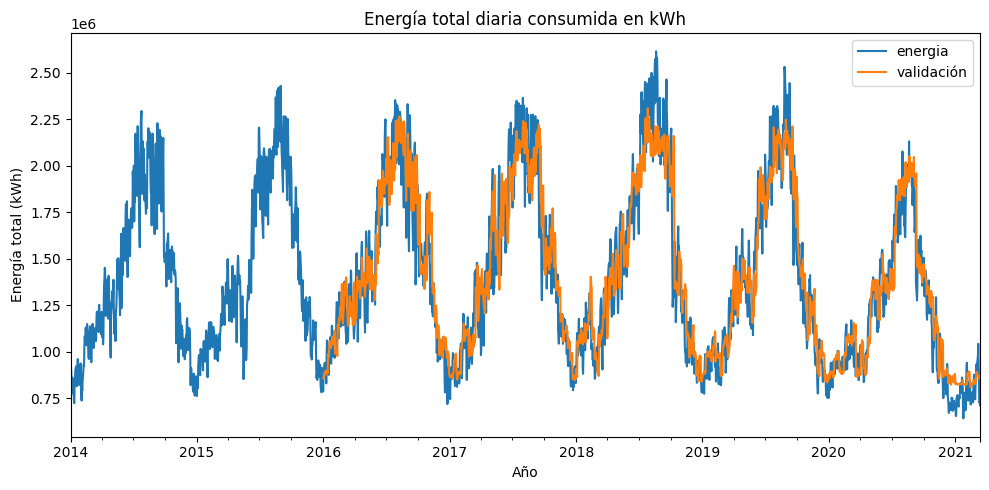

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax)
predictions_back['pred'].plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Energía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend(labels=['energia','validación'])
fig.tight_layout()
plt.show()

Vemos que el modelo se comporta también muy bien a la hora de predecir los ejemplos de training.

### Random Forest

Creamos nuestro modelo de Random Forest. Al igual que antes usaremos predicción recursiva.

In [ ]:

# Creamos el modelo con predicción recursiva
from sklearn.ensemble import RandomForestRegressor


forecaster_RandomForest = ForecasterRecursive(
                 regressor       = RandomForestRegressor(random_state=123, n_jobs=-1,),
                 lags            = 365, #este valor se sobreecribe en la búsqueda de hiperparámetros
                 differentiation = None
             )

Creamos de nuevo el grid de lags con los mismos valores que antes. Creamos nuestro grid para el Random Forest incluyendo los valores por defecto del método.

In [ ]:
lags_grid = [7, 30, 183 ,365]

#Creamos el grid de hiperparámetros
param_grid_RandomForest = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3,5, 8],
}

Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días; un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo; una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, no usamos diferenciación porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 

Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días. Usamos un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo. Cuanto más grande sea este valor, menos pliegues tendremos en la validación cruzada. Consideramos 2 años justos como para tener suficientes datos y no tener demasiados pliegues. No reentrenamos el modelo en cada pliegue. Usamos una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, **no usamos diferenciación** porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 

In [ ]:
cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = 730,
         fold_stride           = None,
         window_size           = 365,
         refit                 = False,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation       = None,
         verbose               = False
     )

Pasamos a entrenar nuestro modelo mediante búsqueda de hiperparámetros.

In [ ]:
results_grid_RandomForest = grid_search_forecaster(
                   forecaster         = forecaster_RandomForest,
                   y                  = energia_train,
                   param_grid         = param_grid_RandomForest,
                   lags_grid          = lags_grid,
                   cv                 = cv,
                   metric             = 'root_mean_squared_scaled_error',
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Vemos que los mejores parámetros son **5** para max_depth y **100** para n_estimators. La métrica de raíz de error cuadrático medio escalado del mejor modelo ha sido de **1.42**, mucho mejor que el modelo baseline (con un RMSSE de **5.567**).

Veamos los parámetros del mejor modelo.

In [ ]:
forecaster_RandomForest


Vemos que ahora el mejor lag es 30. Volvemos a hacer las predicciones usando el primer método para ver cómo se comporta este modelo.

In [ ]:
predicciones_grid = forecaster_RandomForest.predict(steps=len(energia_test))
predicciones_grid

No podemos decir gran cosa a simple vista de estos valores. Comprobamos gráficamente cómo se parecen a los datos reales de test.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predicciones_grid.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

Sigue ocurriendo lo mismo que con el anterior modelo: estamos pidiéndole predecir demasiados valores para un modelo entrenado para un horizonte de 7 días. Como es predicción recursiva, los errores se acumulan y las predicciones se van quedando en torno al mismo valor. Generamos de nuevo las predicciones con el método alternativo.

In [ ]:
# predicción por bloques según steps sin refit, cortesía del chat de copilot

history_last = energia_train.copy()
pred_blocks = []
steps = 7   # número de días a predecir

# obtenemos número de lags del modelo
lags = forecaster_RandomForest.lags
print('lags used:', lags)
block = lags if isinstance(lags, int) else max(lags)
nlags = lags if isinstance(lags, int) else max(lags)
# Recorremos el conjunto de test por bloques de 'steps', añadiendo al historial los valores reales del test
for i in range(0, len(energia_test),steps):
    
     # last_window como pd.Series
    last_window = history_last.iloc[-nlags:]  
    # hacemos la predicción usando el último bloque del historial como last_window
    y_pred = forecaster_RandomForest.predict(steps=steps, last_window=last_window)
    pred_blocks.append(y_pred)
    # añadimos valores reales del test al historial para el siguiente bloque (sin refit)
    history_last = pd.concat([history_last, energia_test.iloc[i:i+steps]])

# concatenar y evaluar
predictions_grid = pd.concat(pred_blocks)
print('shape preds, test:', predictions_grid.shape, energia_test.shape)

Vemos los nuevos valores de las predicciones.

In [ ]:
predictions_grid

Comprobamos gráficamente cómo se parecen a los datos reales de test.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predictions_grid.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

Vemos las métricas de error de estas predicciones.

In [ ]:
error_mae = mean_absolute_error(
                y_true = energia_test,
                y_pred = predictions_grid
            )
print(f"Error absoluto medio (mae): {error_mae:.3f}")

error_rmse = root_mean_squared_error(
                y_true = energia_test,
                y_pred = predictions_grid
            )
print(f"Raíz del error cuadrático medio (rmse): {error_rmse:.3f}")

error_rmsse = root_mean_squared_scaled_error(
                y_true = energia_test,
                y_pred = predictions_grid,
                y_train = energia_train
            )
print(f"Raíz del error cuadrático medio escalado (rmsse): {error_rmsse:.3f}")

# Crear diccionario con resultados
resultadosRF = {
        'Modelo': 'Random Forest',
        'MAE': error_mae,
        'RMSE': error_rmse,
        'RMSSE': error_rmsse
    }
# Guardamos los resultados del modelo
metricas_modelos.append(resultadosRF)

Ahora, generando las predicciones de esta manera, obtenemos un **MAE del 101592.467**, un **RMSE del 137781.279** y un **RMSSE del 1.319**. Valores que son mucho mejores que cuando calculamos de esta manera las predicciones y que nos demuestran que el modelo se comporta muy bien cuando quiere predecir sólo los próximos 7 días siguientes. Mejoran mucho las medidas del modelo baseline pero son algo inferiores a los del modelo XGBoost.

Por último hacemos el backtesting de los datos de training.

In [ ]:
error, predictions_back = backtesting_forecaster(
                          forecaster            = forecaster_RandomForest,
                          y                     = energia_train,
                          cv                    = cv,
                          metric                = 'root_mean_squared_scaled_error',
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print(f'Raíz del error cuadrático medio escalado (rmsse) en validación: {error['root_mean_squared_scaled_error'][0]:.3f}')

Tras el backtesting obtenemos un **RMSSE de 1.424** en el conjunto de entrenamiento. No parece haber ningún tipo de overfitting: tenemos poca diferencia entre ambos errores. De hecho, tenemos incluso mejores medidas para el error de test que el de training (para test 1.319). 

Vemos gráficamente las predicciones del backtesting.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax)
predictions_back['pred'].plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Energía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend(labels=['energia','validación'])
fig.tight_layout()
plt.show()

Vemos que el modelo también predice muy bien los casos de training.

### SVR

Entrenamos por último nuestro modelo de SVR ajustándolo mediante grid de hiperparámetros. Volvemos a usar predicción recursiva. 

In [ ]:
# Creamos el modelo con predicción recursiva
from sklearn.svm import SVR


forecaster_SVR = ForecasterRecursive(
                 regressor       = SVR(),
                 lags            = 365, #este valor se sobreecribe en la búsqueda de hiperparámetros
                 differentiation = None
             )

Creamos de nuevo el grid de lags con los mismos valores que antes. Creamos nuestro grid para el SVR incluyendo los valores por defecto del método.

In [ ]:
lags_grid = [7, 30, 183 ,365]

#Creamos el grid de hiperparámetros
param_grid_SVR = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1]
}

Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días; un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo; una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, no usamos diferenciación porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 

Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días. Usamos un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo. Cuanto más grande sea este valor, menos pliegues tendremos en la validación cruzada. Consideramos 2 años justos como para tener suficientes datos y no tener demasiados pliegues. No reentrenamos el modelo en cada pliegue. Usamos una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, **no usamos diferenciación** porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 

In [ ]:
cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = 730,
         fold_stride           = None,
         window_size           = 365,
         refit                 = False,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation       = None,
         verbose               = False
     )

Pasamos a entrenar el modelo con el grid de hiperpárametros.

In [ ]:
results_grid_SVR = grid_search_forecaster(
                   forecaster         = forecaster_SVR,
                   y                  = energia_train,
                   param_grid         = param_grid_SVR,
                   lags_grid          = lags_grid,
                   cv                 = cv,
                   metric             = 'root_mean_squared_scaled_error',
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Vemos que los mejores parámetros son **10** para la variable C, **0.5** para epsilon y el valor **scale** para la variable gamma. La métrica de raíz de error cuadrático medio escalado del mejor modelo ha sido de **3.89**, mejor que el modelo baseline (con un RMSSE de **5.567**) pero peor que los otros dos modelos.

Veamos los parámetros del mejor modelo.

In [ ]:
forecaster_SVR

Vemos que ahora el mejor valor de lag es 183. Volvemos a hacer las predicciones de la forma inicial.

In [ ]:
predicciones_grid = forecaster_SVR.predict(steps=len(energia_test))
predicciones_grid

Los valores no parecen muy correctos. Veámoslos gráficamente.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predicciones_grid.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

Vemos que ahora los valores del modelo se sitúan en torno a la media. Calculemos las predicciones de la segunda manera.

In [ ]:
# predicción por bloques según steps sin refit, cortesía del chat de copilot

history_last = energia_train.copy()
pred_blocks = []
steps = 7   # número de días a predecir

# obtenemos número de lags del modelo
lags = forecaster_SVR.lags
print('lags used:', lags)
block = lags if isinstance(lags, int) else max(lags)
nlags = lags if isinstance(lags, int) else max(lags)
# Recorremos el conjunto de test por bloques de 'steps', añadiendo al historial los valores reales del test
for i in range(0, len(energia_test),steps):
    
     # last_window como pd.Series
    last_window = history_last.iloc[-nlags:]  
    # hacemos la predicción usando el último bloque del historial como last_window
    y_pred = forecaster_SVR.predict(steps=steps, last_window=last_window)
    pred_blocks.append(y_pred)
    # añadimos valores reales del test al historial para el siguiente bloque (sin refit)
    history_last = pd.concat([history_last, energia_test.iloc[i:i+steps]])

# concatenar y evaluar
predictions_grid = pd.concat(pred_blocks)
print('shape preds, test:', predictions_grid.shape, energia_test.shape)

Veamos cómo son los nuevos valores.

In [ ]:
predictions_grid

Siguen pareciendo anormales. Veámoslos graficados.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predictions_grid.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

No han cambiado de esta manera. Con este método, el modelo lo que hace es ajustarse a la media de la serie temporal. Quizás haya que reducir la ventana temporal. Comprobemos las métricas de error de estas predicciones.

In [ ]:
error_mae = mean_absolute_error(
                y_true = energia_test,
                y_pred = predictions_grid
            )
print(f"Error absoluto medio (mae): {error_mae:.3f}")

error_rmse = root_mean_squared_error(
                y_true = energia_test,
                y_pred = predictions_grid
            )
print(f"Raíz del error cuadrático medio (rmse): {error_rmse:.3f}")

error_rmsse = root_mean_squared_scaled_error(
                y_true = energia_test,
                y_pred = predictions_grid,
                y_train = energia_train
            )
print(f"Raíz del error cuadrático medio escalado (rmsse): {error_rmsse:.3f}")

# Crear diccionario con resultados
resultadosSVR = {
        'Modelo': 'SVR',
        'MAE': error_mae,
        'RMSE': error_rmse,
        'RMSSE': error_rmsse
    }
# Guardamos los resultados del modelo
metricas_modelos.append(resultadosSVR)

Ahora, generando las predicciones de esta manera, obtenemos un **MAE del 388456.054**, un **RMSE del 433114.408** y un **RMSSE del  4.145**. Vemos que no obtenemos unos resultados muy buenos. Ni siquiera cuando vamos generando las predicciones cada 7 días. Mejoran las medidas del modelo baseline pero son muy inferiores a las de los otros dos modelos.

Por último, hacemos el backtesting de los datos de training para ver si hay overfitting.

In [ ]:
error, predictions_back = backtesting_forecaster(
                          forecaster            = forecaster_SVR,
                          y                     = energia_train,
                          cv                    = cv,
                          metric                = 'root_mean_squared_scaled_error',
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print(f'Raíz del error cuadrático medio escalado (rmsse) en validación: {error['root_mean_squared_scaled_error'][0]:.3f}')

Tras el backtesting obtenemos un **RMSSE de 3.897** en el conjunto de entrenamiento. No parece ajustar bien los datos, más bien parece haber underfitting. 

Vemos gráficamente las predicciones del backtesting.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax)
predictions_back['pred'].plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Energía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend(labels=['energia','validación'])
fig.tight_layout()
plt.show()

El modelo no ajusta nada bien los datos. Al igual que antes, el modelo parece predecir la media.

## Comparación de modelos y conclusiones

Ahora compararemos los resultados obtenidos por cada uno de nuestros modelos.

In [ ]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(metricas_modelos)
df_resultados = df_resultados.sort_values('RMSSE')

print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'Baseline']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSE', 'RMSSE'], cmap='RdYlGn_r')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}'}))

Vemos como para todas las métricas, el modelo XGBoost resulta el mejor de todos. Tras el ajuste de hiperparámetros conseguimos `un MAE de 100205.798173, un RMSE de 134252.747876 y un RMSSE de 1.284951`, que es la que consideramos la medida más importante. Conseguimos hasta una mejora del **76.92 %** con respecto al modelo baseline, cuyos resultados han podido ser mejorados por todos los modelos. El modelo Random Forest nos da unas métricas similares al XGBoost pero algo peores. Por último, el modelo SVR nos ofrece unos resultados que, aunque consigan mejorar el rendimiento del modelo baseline, resultan mediocres en comparación con los otros dos.

`Por tanto, finalmente nos quedamos con el modelo XGBoost para hacer la predicción de 7 días con un modelo univariante.`

## Consultas a IA generativa

***1. He entrenado un modelo para predecir un horizonte temporal de 7 dias. Si tengo un conjunto de test de 658 valores, cómo evalúo correctamente las predicciones del modelo entrenado para steps=7 ¿Cómo harias para predecir en bloques de 7 en 7 usando el set de test? No quiero hacer refit en cada bloque***

**Respuesta:** # 
        ...existing code...
        # predicción en bloques de 7 sin refit
        block = 7
        history_last = energia_train.copy()
        pred_blocks = []

        # obtener número de lags del forecaster
        lags = forecaster_RandomForest.lags
        nlags = lags if isinstance(lags, int) else max(lags)

        for i in range(0, len(energia_test), block):
            steps = min(block, len(energia_test) - i)
            last_window = history_last.iloc[-nlags:].values
            y_pred = forecaster_RandomForest.predict(steps=steps, last_window=last_window)
            pred_blocks.append(y_pred)
            # añadir valores reales del test al historial para el siguiente bloque (sin refit)
            history_last = pd.concat([history_last, energia_test.iloc[i:i+steps]])

        # concatenar y evaluar
        predictions = pd.concat(pred_blocks)
        print('shape preds, test:', predictions.shape, energia_test.shape)
        from sklearn.metrics import mean_absolute_error
        print('MAE:', mean_absolute_error(energia_test, predictions))
        # ...existing code...

## Librerías utilizadas

In [ ]:
import session_info
# En versiones más recientes de python (3.12.7), este es el comando

session_info.show()